# Predicting sentiment from product reviews


In [290]:
import math
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer

sns.set()
%matplotlib inline

# Data preparation

In [291]:
products = pd.read_csv('food_products.csv')

np.random.seed(416)

products.head()

,product_id,summary,review,rating
0,4408,Does increase milk supply,This really helped to increase my milk supply....,3.0
1,4209,One bad packet ruins the product!,I should have stayed with Idahoan brand. Poor ...,1.0
2,8623,CAULIFLOWER PASTA!?,"As the pasta cooked, I read the box to see wha...",4.0
3,9439,Tasty and inexpensive,I really like this cereal. The flavor is sligh...,5.0
4,7110,I'm Confused,The label on the bowl says 35 grams is in the ...,2.0


Do not modify the below cell. It configures the autograder, which will award 0 points if it doesn't run.

## Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment. Let's see how many of each rating we have.

In [292]:
products = products[products['rating'] != 3].copy()

len(products)

889

<Axes: title={'center': 'Number of reviews with a given rating'}, xlabel='rating', ylabel='Count'>

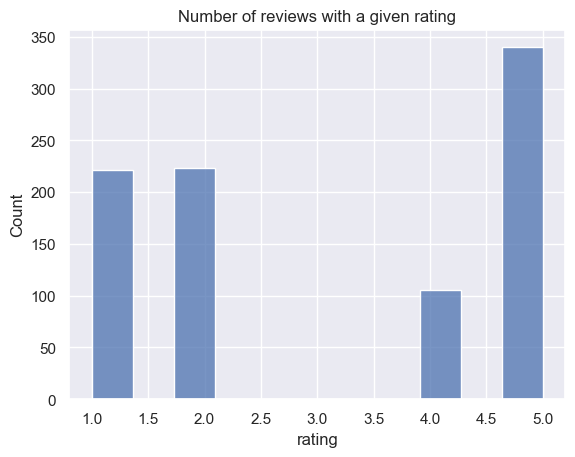

In [293]:
plt.title('Number of reviews with a given rating')
sns.histplot(products['rating'])

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [294]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
products.head()

,product_id,summary,review,rating,sentiment
1,4209,One bad packet ruins the product!,I should have stayed with Idahoan brand. Poor ...,1.0,-1
2,8623,CAULIFLOWER PASTA!?,"As the pasta cooked, I read the box to see wha...",4.0,1
3,9439,Tasty and inexpensive,I really like this cereal. The flavor is sligh...,5.0,1
4,7110,I'm Confused,The label on the bowl says 35 grams is in the ...,2.0,-1
5,1373,Flat,Doesn't taste like ginger. Thought it would s...,2.0,-1


Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

## Build the word count vector for each review

Let us explore a specific example of a food product. We have information about the product, the review left, and both the rating that was given and the sentiment label we computed.

In [295]:
example_product = products.iloc[21]
print(f"Rating : {example_product['rating']} (Sentiment={example_product['sentiment']})")
print("Summary:", example_product["summary"])
print("Review :", example_product["review"])

Rating : 4.0 (Sentiment=1)
Summary: It's PRIME-arily Lobster
Review : if it's primarily made from lobster, what else is in there? I wonder. Primarily...Who uses a word like that on a food label? It's primarily delicious among other things, things we usually have no energy to talk about after eating a fine meal. I'm so full of primarily lobster bisque that I've been making and have come to be addicted to. NO! I will not share the recipe, because I am too full and don't feel like it. Primarily.


To work with the text data, we will need to turn it into a vector of word counts. In other words, we will be making a feature for every word that could possibly appear in the data, and the value for that feature for one example would be the number of times that word appears in that example. 

So first, we remove punctuation with the code in the next cell.

In [296]:
def remove_punctuation(text):
    """
    Remove any punctuation in text. Python has a default set of 
    punctuation marks, stored in string.punctuation, that contains
    !"#$%&'()*+, -./:;<=>?@[\\]^_`{|}~
    """
    if type(text) is str:
        return text.translate(str.maketrans('', '', string.punctuation))
    else:
        return ''
    
products['review_clean'] = products['review'].apply(remove_punctuation)

Next, we use scikit-learn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to get counts for each word. 

In [297]:
# Make counts
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(products['review_clean'])

# Get the feature names (e.g., one per word)
features = vectorizer.get_feature_names_out()

# Make a new DataFrame with the counts information
product_data = pd.DataFrame(count_matrix.toarray(),
        index=products.index,
        columns=features)

# Add the old columns to our new DataFrame. 
# We won't use review_clean and the summary in our model, but we will keep
# them to look at later.
product_data['sentiment'] = products['sentiment']
product_data['review_clean'] = products['review_clean']  
product_data['summary'] = products['summary']

product_data.head()

,0000,002,004,004oz,012months,032,051,08,0f,10,...,zico1,zico3,zicos,zillion,zinger,zip,ziplock,sentiment,review_clean,summary
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,I should have stayed with Idahoan brand Poor B...,One bad packet ruins the product!
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,As the pasta cooked I read the box to see what...,CAULIFLOWER PASTA!?
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,I really like this cereal The flavor is slight...,Tasty and inexpensive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,The label on the bowl says 35 grams is in the ...,I'm Confused
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,Doesnt taste like ginger Thought it would sav...,Flat


## Split data into training, validation and test sets.

In [298]:
train_data, test_and_validation_data = train_test_split(product_data, test_size=0.2, random_state=3)
validation_data, test_data = train_test_split(test_and_validation_data, test_size=0.5, random_state=3)

# Baseline: Majority class prediction

It is quite common to use the **majority class classifier** as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points.

To "train" the majority class classifier, you should simply find the most frequent target in the training data.

### **Question 1:** Majority class classifier
* Compute the most frequent label and store it in a variable called `majority_label`.
* What is the validation accuracy of the majority class classifer. Store your result as a number between 0 and 1 in a variable called `majority_classifier_validation_accuracy`.
  
  *Hint:* pandas allows you to take the sum of a boolean series - true values are equal to 1, false values are equal 0.

In [299]:
majority_label = train_data['sentiment'].value_counts().idxmax()

predictions = [majority_label] * len(validation_data)
majority_classifier_validation_accuracy = (predictions == validation_data['sentiment']).mean()
print(f"majority_classifier_validation_accuracy: {majority_classifier_validation_accuracy}")

majority_classifier_validation_accuracy: 0.5168539325842697


# Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data. This model will use the columns representing word counts as features and the column **sentiment** as the target. We will set **no regularization penalty**, and set `random_state=1` to get the same answer as everyone else.

In [300]:
sentiment_model = LogisticRegression(penalty='l2', C=1e23, random_state=1)
sentiment_model.fit(train_data[features], train_data['sentiment'])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1e+23
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [301]:
coefficients = sentiment_model.coef_

print('Smallest coefficient', coefficients.min())
print('Largest coefficient:', coefficients.max())

Smallest coefficient -5.987646623431772
Largest coefficient: 11.015982338842834


### **Question 2:** Most Positive/Negative Word
For the sentiment model we trained above, compute the word with the most negative weight and the word with the most positive weight.

In [302]:
word_coefficients = dict(zip(features, sentiment_model.coef_[0]))

most_negative_word = min(word_coefficients, key=word_coefficients.get)
most_positive_word = max(word_coefficients, key=word_coefficients.get)

In [303]:
print('Most negative word:', most_negative_word)
print('Most positive word:', most_positive_word)

Most negative word: not
Most positive word: great


## Making predictions with logistic regression

Now that a model is trained, we can make predictions on the **validation data**. In this first section, we will restrict the examples we are looking at to 3 examples in the validation dataset. We refer to this set of 3 examples as the **sample_data**.

In [304]:
sample_data = validation_data[8:11]
sample_data[['sentiment', 'review_clean', 'summary']]

,sentiment,review_clean,summary
493,-1,The Chocolate Espresso flavor of the thinkThin...,Not a good taste
311,1,hard candy with a smooth creamy milk taste i l...,great taste
570,1,When I was growing up split pea soup was a uni...,More like split pea stew


### Predicting sentiment
Let's start by predicting the probability of positive/negative sentiment of the 3 examples in the `sample_data`. The `predict_proba` method on the `LogisticRegression` class outputs a probability for each class possible.

In [305]:
print('  Prob Negative, Prob Positive')
print(sentiment_model.predict_proba(sample_data[features]))

  Prob Negative, Prob Positive
[[1.00000000e+00 4.94811120e-17]
 [1.81738360e-07 9.99999818e-01]
 [1.00000000e+00 1.07223685e-11]]


We are also able to predictions labels (i.e., $\pm1$, not just probabilities) using the `predict` function.

In [306]:
print('Predicted labels')
print(sentiment_model.predict(sample_data[features]))

Predicted labels
[-1  1 -1]


### **Question 3:** Find the review predicted to be most positive (and negative)

We now turn to examining the full **validation_data** dataset <span style="color:red">(not sample_data)</span>, , and use `sklearn` to form predictions on all of the data points for faster performance.

Using the `sentiment_model`, find the review in the **validation_data** with the **highest probability** of being classified as a **positive review**. Also, find the review with the **highest probability** of being classified as a **negative review**. We refer to these as the "most positive review" and "most negative review" respectively. Store the `review_clean` column value for each of these rows in `most_positive_review` and `most_negative_review` variables respectively.

In [307]:
validation_probs = sentiment_model.predict_proba(validation_data[features])

most_positive_index = validation_probs[:,1].argmax()
most_negative_index = validation_probs[:,0].argmax()

most_positive_review = validation_data.iloc[most_positive_index]['review_clean']
most_negative_review = validation_data.iloc[most_negative_index]['review_clean']

In [308]:
print('Most Positive Review:')
print(most_positive_review)
print()
print('Most Negative Review:')
print(most_negative_review)

Most Positive Review:
I have been on an organic foods diet for almost a year now and I have become much more sensitive to what I eat and drink Out are the energy drinks loaded with sugars caffeine and artificial ingredients In are the more gentler and natural energy boosters This was  a surprise for me I really liked it and it did give an energy boost without any late energy crashesThe flavor is nice A good palatable taste and feel in the mouth No bad after taste It sits well on the stomach even an empty one It provides and fairly quick ramp up in energy and alertness and lasts for several hours to all day The ramp down in gently and hardly noticeable I like the ingredients and the overall effectI am finding that I need less energy boosting as my diet is becoming cleaner and healthier However I am going to rely on these until the day when I can maintain great energy levels without supports Or at least keeps a few in the fridge for special occasions 5 Stars easy Hope you get as much out

### **Question 4:** Compute validation accuracy
Compute the validation accuracy for the model we just trained. Report the validation accuracy as a number between 0 and 1 stored in a variable called `sentiment_model_validation_accuracy`.

In [309]:
val_predict = sentiment_model.predict(validation_data[features])
sentiment_model_validation_accuracy = accuracy_score(validation_data['sentiment'], val_predict)

# Create a confusion matrix

A common tool used when analyzing the peformance of a predictor in a classification problem is to look at the confusion matrix, as well as the overall accuracy.

We've created a function that will plot a confusion matrix for you given a set of inputs which are the values that should appear within each cell.
Recall that there are four values associated with a confusion matrix: true positive, true negative, false positive, and false negative which we will abberviate as TP, TN, FP, and FN, respecitvely. In other words, for the next problem we have handled the plotting code for you that you can use, but you will need to compute the values for each of the confusion matrix dimensions.

In [310]:
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values 
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg']) 

### **Question 5:** Compute confusion matrix values and plot

Write code below that uses the `plot_confusion_matrix` function to show the number of true positive, true negative, false positive, and false negative predictions made by your classifier on the validation set. You should store the counts for each of these values in the variables:
* `tp`
* `fp`
* `fn`
* `tn` 

In [311]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(validation_data['sentiment'], val_predict, labels=[1, -1])

tp = cm[0, 0]
fp = cm[1, 0]
tn = cm[1, 1]
fn = cm[0, 1]

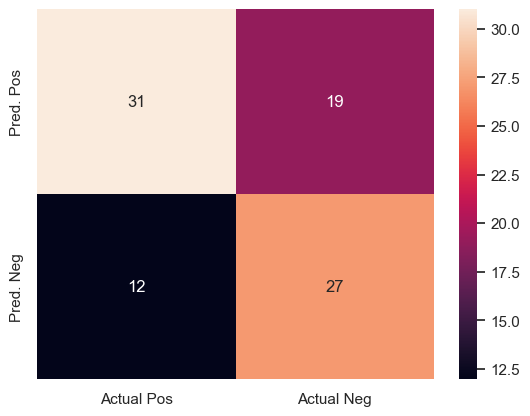

In [312]:
plot_confusion_matrix(tp=tp, fp=fp, tn=tn, fn=fn)

## **Question 6 and 7**: Logistic Regression with L2 regularization

One of the challenges of creating features from each word is that there are many more features than observations. It is easy to overfit. We will explore the effect of the regularization in this problem.

### **Question 6:** Coefficient Paths
For this question we will ask you to compute the coefficent path for each of the features in the model for various values of the regularization constant.

For each regularization strength, train a model using that regularization constant and create a table storing the coefficients of each learned predictor. Store the results in a `DataFrame` named `coef_table`.

You should end up with an `DataFrame` with column names as `'coefficients [L2=1e-02]', ... 'coefficients [L2=1e+05]'`, and a row for each word in `features`. It should look something like the following:

|     | word | coefficients [L2=1e-02] | coefficients [L2=1e+00] | ... | coefficients [L2=1e+05] |
|-----|------|-------------------------|-------------------------|-----|-------------------------|
| 0   |  word1 |           ...           |           ...           | ... |           ...           |
| 1   |  word2 |           ...           |           ...           | ... |           ...           |
| ... |  ..  |           ...           |           ...           | ... |           ...           |

Before the loop, we set up `coef_table` to have the right rows and columns, but your code will need to fill out the rest.

### **Question 7:** Train and Validation Accuracies
Similar to Q6, we want you to compute the training and validation accuracy for each learned predictor and store that in a `DataFrame` called `accuracies_table`. 

You should end up with a `DataFrame` with column names `'l2_penalty', 'train_accuracy', 'validation_accuracy'` and a row for each L2 penalty tried. The L2 penaly should be the number (not the column name from Q7) and the accuracy values should be numbers between 0 and 1 for the appropriate accuracy. It should look something like the following:

|     | l2_penalty | train_accuracy | validation_accuracy |
|-----|------------|----------------|---------------------|
| 0   |    0.01    |       ...      |         ...         |
| 1   |      1     |       ...      |         ...         |
| ... |     ..     |       ...      |         ...         |

For this problem, we recommend the approach used in HW1 to build up a list of dictionaries, and then convert that to a `DataFrame` with the values described.

### Implementation Details

Some important notes about your implementation:
*  When constructing a `LogisticRegression` object, make sure to use `random_state=1` to get the same results as us. We also want to avoid having an intercept term in this example, so also pass `fit_intercept=False` when constructing the `LogisticRegression` model.
* <span style="color:red">When constructing the LogisticRegression(...) model, the parameter `C` is the **inverse** of $\lambda$ (i.e., $C=\frac{1}{\lambda}$). </span>
* Q7: To store the results of your predictor's coefficients, you will need to get the values from the `.coef_` property. Since the code for this is a little complex, we give you this line below (assumes your trained model is stored in a variable called `model`):
  ```
  coef_table[column_name] = model.coef_[0]
  ```

* It is okay if your code prints `ConvergenceWarnings`. This is something you would want to avoid in practice but is okay in our assignment for simplicity.

* We recommend just focusing on Q6 at first and getting the code to set up the coefficients table right. Then once that's working, evaluate the models for Q7.


In [313]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

l2_penalties = [0.01, 1, 4, 10, 1e2, 1e3, 1e5]
l2_penalty_names = [f'coefficients [L2={l2_penalty:.0e}]' 
                    for l2_penalty in l2_penalties]

coef_table = pd.DataFrame(columns=['word'] + l2_penalty_names)
coef_table['word'] = features

accuracy_data = []

for l2_penalty, l2_penalty_column_name in zip(l2_penalties, l2_penalty_names):

    model = LogisticRegression(
        penalty='l2',
        C=1/l2_penalty,
        fit_intercept=False,
        random_state=1,
        solver='saga'
    )
    model.fit(train_data[features], train_data['sentiment'])
    
    coef_table[l2_penalty_column_name] = model.coef_[0]

    train_preds = model.predict(train_data[features])
    val_preds = model.predict(validation_data[features])
    
    train_accuracy = accuracy_score(train_data['sentiment'], train_preds)
    val_accuracy = accuracy_score(validation_data['sentiment'], val_preds)

    accuracy_data.append({
        'l2_penalty': l2_penalty,
        'train_accuracy': train_accuracy,
        'validation_accuracy': val_accuracy
    })
    
accuracies_table = pd.DataFrame(accuracy_data)

/Users/ameliali/GitHub/CSE416/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ameliali/GitHub/CSE416/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ameliali/GitHub/CSE416/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ameliali/GitHub/CSE416/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ameliali/GitHub/CSE416/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [314]:
coef_table

,word,coefficients [L2=1e-02],coefficients [L2=1e+00],coefficients [L2=4e+00],coefficients [L2=1e+01],coefficients [L2=1e+02],coefficients [L2=1e+03],coefficients [L2=1e+05]
0,0000,0.003667,0.003649,0.003597,0.003494,0.002380,0.000475,5.048222e-06
1,002,-0.000900,-0.000896,-0.000883,-0.000859,-0.000585,-0.000099,-4.086077e-06
2,004,-0.000900,-0.000896,-0.000883,-0.000859,-0.000585,-0.000099,-4.086077e-06
3,004oz,-0.000900,-0.000896,-0.000883,-0.000859,-0.000585,-0.000099,-4.086077e-06
4,012months,0.001912,0.001902,0.001874,0.001820,0.001279,0.000399,5.052150e-06
...,...,...,...,...,...,...,...,...
7620,zicos,-0.004237,-0.004215,-0.004151,-0.004026,-0.002664,-0.000446,-4.925817e-06
7621,zillion,-0.004387,-0.004365,-0.004298,-0.004168,-0.002756,-0.000466,-4.976211e-06
7622,zinger,-0.003216,-0.003201,-0.003157,-0.003070,-0.002116,-0.000411,-4.895829e-06
7623,zip,0.007254,0.007221,0.007121,0.006929,0.004820,0.001036,1.028767e-05


In [315]:
accuracies_table

,l2_penalty,train_accuracy,validation_accuracy
0,0.01,0.880450,0.696629
1,1.00,0.879044,0.696629
2,4.00,0.879044,0.696629
3,10.00,0.879044,0.696629
4,100.00,0.873418,0.685393
5,1000.00,0.732771,0.674157
6,100000.00,0.502110,0.516854


## **Question 8:** Inspect Coefficients

We'll now look at the **coefficients** for the model that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

In [316]:
column_name = 'coefficients [L2=1e+00]'

positive_words = coef_table.nlargest(5, column_name)['word']
negative_words = coef_table.nsmallest(5, column_name)['word']

In [317]:
print(positive_words)
print(negative_words)

3096    great
3037     good
7478     with
2800      for
7424     when
Name: word, dtype: object
4586      not
6695    taste
7346      was
799        be
1134      but
Name: word, dtype: object


Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

<>:44: SyntaxWarning: invalid escape sequence '\l'
<>:44: SyntaxWarning: invalid escape sequence '\l'
/var/folders/0m/lnjvgdwn25b81nfv_3691wtc0000gn/T/ipykernel_44785/2950039924.py:44: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('L2 penalty ($\lambda$)')


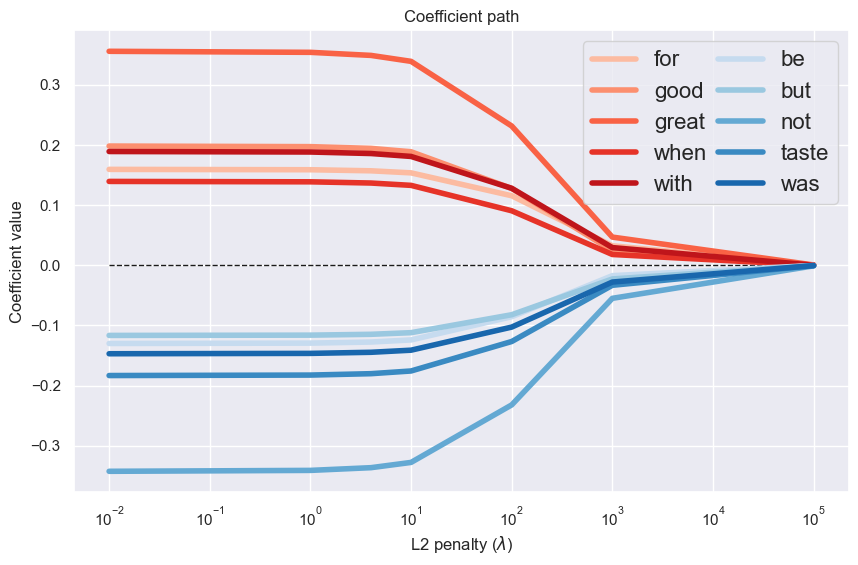

In [318]:
def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    """
    Makes a plot of coefficients, given a table where rows correspond to words and
    columns correspond to the l2 penalty, a list of positive words, a list of 
    negative words, and a list of l2 penalties.
    """
    def get_cmap_value(cmap, i, total_words):
        """
        Computes a nice scaling of from i=0 to i=total_words - 1
        for the given cmap
        """
        return cmap(0.8 * ((i + 1) / (total_words * 1.2) + 0.15))


    def plot_coeffs_for_words(ax, words, cmap):
        """
        Given an axes to plot on and a list of words and a cmap,
        plots the coefficient paths for each word in words
        """
        words_df = table[table['word'].isin(words)]
        words_df = words_df.reset_index(drop=True)  # To make indices sequential

        for i, row in words_df.iterrows():
            color = get_cmap_value(cmap, i, len(words))
            ax.plot(xx, row[row.index != 'word'], '-',
                    label=row['word'], linewidth=4.0, color=color)

    # Make a canvas to draw on
    fig, ax = plt.subplots(1, figsize=(10, 6))
   
    # Set up the xs to plot and draw a line for y=0
    xx = l2_penalty_list
    ax.plot(xx, [0.] * len(xx), '--', linewidth=1, color='k')

    # Plot the positive and negative coefficient paths
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    plot_coeffs_for_words(ax, positive_words, cmap_positive)
    plot_coeffs_for_words(ax, negative_words, cmap_negative)

    # Set up axis labels, scale, and legend  
    ax.legend(loc='best', ncol=2, prop={'size':16}, columnspacing=0.5 )
    ax.set_title('Coefficient path')
    ax.set_xlabel('L2 penalty ($\lambda$)')
    ax.set_ylabel('Coefficient value')
    ax.set_xscale('log')


make_coefficient_plot(coef_table, positive_words, negative_words, l2_penalty_list=l2_penalties)